The goal here is just to have a function that takes as arguments 
a graph 
its number of nodes 
and number of edges 
and a certain exponent gamma
a certain maximum time t_max

In [1]:
import networkit as nk
import numpy as np
import saw_sampler_core as saw
import copy

### Core SAW sampler functions
All the code of the MCMC is contained in the next one 'saw_sampler_core' file.
in this cell we recall the basic organization of the algorithm.

We will indicate with $\pi=(\pi_1,\dots,\pi_{L(\pi)})$ a path going from $\pi_1$ to $\pi_{L(\pi)}$. $L(\pi)$ indicates the number of nodes in the path. Consider a graph with edges weighted with the matrix $W\in\mathbb R^{N\times N}$. $W_{ij}$ represents the cost for the walk to traverse edge $i\to j$. With use the notation $\pi_{:k}$ and $\pi_{k:}$ we indicate respectively the first $k$ nodes of path $\pi$, and the nodes from $\pi_k$ (included) to the end of $\pi$. 


The MCMC aims to sample from the Gibbs measure

$$P(\pi|s,t)=\frac{1}{Z(s,t)}e^{-\beta E_W(\pi)}\mathbb I[\pi_1=s]\mathbb I[\pi_{L(\pi)}=e]\mathbb I[\pi \text{ is a SAW}],\quad E_W(\pi)=\sum_{k=1}^{L(\pi)-1} W_{\pi_k,\pi_{k+1}},$$
where $\beta$ is an inverse temperature parameter that determines how peaked the distribution is around the shortest path.
The MCMC at each time step proposes a path from the proposal distribution 
$$Q(\tilde\pi|s,t)=\prod_{k=1}^{L(\pi)-1}q(\tilde\pi_{k+1}|\tilde\pi_{:k},s,t).$$

with 
$$q(\tilde\pi_{k+1}=y|\tilde\pi_{:k},s,t)=\frac{1}{\mathcal Z(x_{:k},s,t)}\mathbb I[y\not \in \tilde\pi_{:k}]\exp\left[-\beta( W_{\tilde\pi_k y}+V_e(y,\tilde\pi_{:k}))\right].$$


Let $\pi$ be the current path in the MCMC. We first propose a new path $\tilde \pi$ by sampling it from a proposal probability $Q(\tilde \pi|s,t)$ and then we accept the move with probability $p_{acc}=\frac{P(\tilde\pi|s,t)Q(\pi|s,t)}{P(\pi|s,t)Q(\tilde \pi|s,t)}$.

# Example
 we now present an example of how the MCMC works on a rangom regular graph. 
 We generage the graph using networkx and then transform it into a networkit graph. In this example the weights in the graph are all set to one (uncommenting a line one can try the case of random weights).

 
 
 


In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
#auxiliary functions to plot the network and the paths
def Plot_network(G): 
    to_plot_graph = nx.Graph()
    N=G.numberOfNodes()
    print(G.numberOfNodes())
    for i in range(N):
        to_plot_graph.add_node(i)
    for u,v in G.iterEdges():
        to_plot_graph.add_edge(u,v)

    weights = [(G.weight(u,v)) for u,v in G.iterEdges()]
    pos= nx.circular_layout(to_plot_graph)
    nx.draw(to_plot_graph,with_labels=True ,width = weights,pos=pos)
    plt.show()


def Plot_network_paths(G, paths): 
    N=G.numberOfNodes()
    G=copy.deepcopy(G) 
    for u,v in G.iterEdges():
        G.setWeight(u,v,1)
    for path in paths:
        for k in range(len(path)-1):
            G.setWeight(path[k],path[k+1],G.weight(path[k],path[k+1])+1)
    to_plot_graph = nx.Graph()
    for i in range(N):
        to_plot_graph.add_node(i)
    for u,v in G.iterEdges():
        to_plot_graph.add_edge(u,v,weight=(G.weight(u,v)))
        
    weights = np.log(np.array([(G.weight(u,v)) for u,v in G.iterEdges()])) #removing the logarithm will givethe whle graph, with thicker edges being those that get traversed the most.
    pos= nx.circular_layout(to_plot_graph)
    nx.draw(to_plot_graph,with_labels=True ,pos=pos,width=weights)
    plt.show()

40


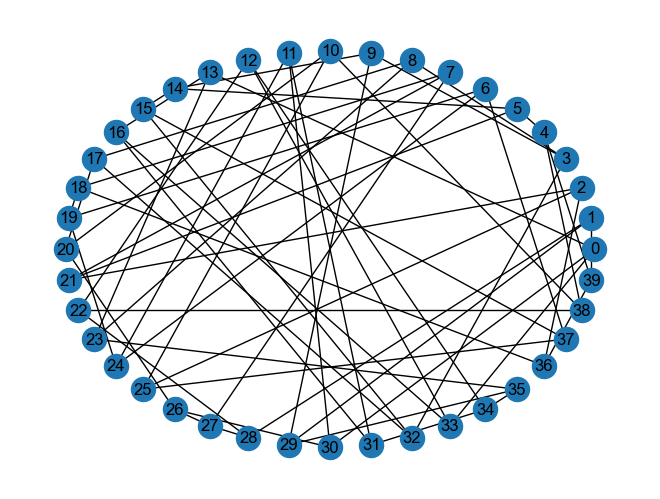

In [4]:
# CREATE THE GRAPH 
N=40 #number of nodes
degree=3 
nx_G=nx.random_regular_graph(d=degree, n=N,seed=1) #generate using networkx library
#nx_G=nx.grid_graph(dim=[100,100],periodic=False) #generate using networkx library

#convert my networkx into a networkit graph, also set the weights
G =nk.graph.Graph(n=N, weighted=True, directed=False)
for edge in nx_G.edges():
    G.addEdge(edge[0],edge[1]) 
    #W=0.4+np.random.exponential(scale=2) #exponential weights
    W=1 #set all weights to 1 
    G.setWeight(edge[0],edge[1],W) 
#plot the graph
if(N<50):
    Plot_network(G)
    


In [6]:
# the MCMC only works with directed graphs, therefore here we create  Gd, a directed version of G.
Gd=nk.graph.Graph(n=N, weighted=True, directed=True, edgesIndexed=False) 
for u,v in G.iterEdges():
    Gd.addEdge(u,v)
    Gd.setWeight(u,v,G.weight(u,v))
    Gd.addEdge(v,u)
    Gd.setWeight(v,u,G.weight(v,u))
    

In [7]:
beta=1
start_node=0
end_node=1
tmax=5000
paths,acceptance_rate=saw.mcmcm_saw(beta, Gd,start_node,end_node, tmax)
print(f"acceptance rate={acceptance_rate:.3f}")

acceptance rate=0.761


Text(0, 0.5, 'energy')

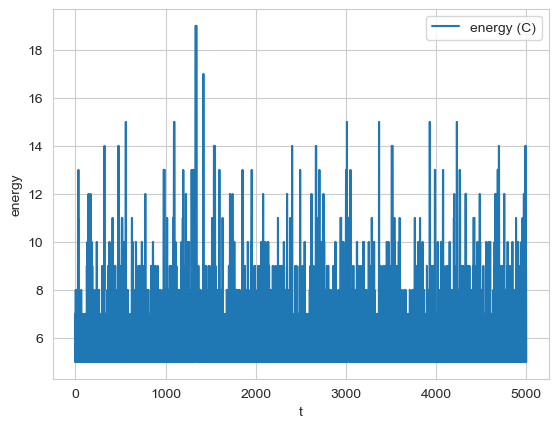

In [8]:
#plt.plot([len(path) for path in paths],label="length")   
energies=[sum([G.weight(path[k],path[k+1]) for k in range(len(path)-1)]) for path in paths]
plt.plot(energies,label="energy (C)")
plt.legend()
plt.xlabel('t')
plt.ylabel('energy')

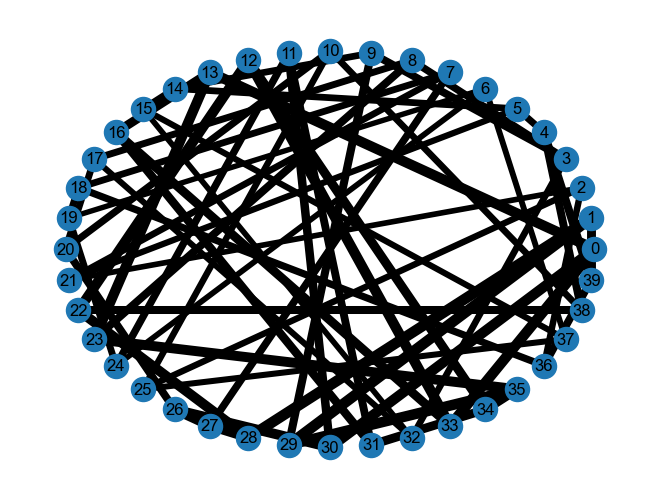

In [9]:
#plotting the distribution of paths over edges of the graph
Plot_network_paths(G, paths)